### Spatial Error Model

This code didn't work until the last day, when we used Google Colab Pro for it.
The final version used around 2000 Matrix Samples (64x64) and needs around 30GB RAM for computing the Distance Matrix

This is the original Colab Notebook, which uses the feature engineered, preprocessed data, which were uploaded to Google Drive

In [ ]:
!pip install libpysal
!pip install pysal

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

ROOT_DIR ='/content/drive/MyDrive/esc403_data_feature_engineered/'

os.chdir(ROOT_DIR)

Mounted at /content/drive


In [3]:
import torch
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
from joblib import load
from pathlib import Path
import os
import numpy as np
import sys
import pandas as pd
from libpysal.weights import Queen, Rook, DistanceBand, lat2W, WSP
from pysal.model import spreg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import block_diag, csr_matrix
import pysal.lib as lib


#### Load Data

This is (unfortunately) just copied code, instead of using our whole setup.
Reads the data from private Google Drive.

In [4]:
testing = False
read_path = r"" if testing else r"later_upload_whole_data"

X = load(ROOT_DIR / Path(read_path, "X_fe.pkl"))
y = load(ROOT_DIR / Path(read_path, "y_fe.pkl"))

In [5]:
## Original (whole) Data:
print(type(X), X.shape)
print(type(y), y.shape)

<class 'torch.Tensor'> torch.Size([18545, 64, 64, 15])
<class 'torch.Tensor'> torch.Size([18545, 64, 64, 1])


#### Preprocessing

Working with the whole dataset was unfortunately impossible.
- We subset only 4000 Samples first.
- Secondly, only those Images were used, which contained not one single cloud in the Firemask (not one -1 in y)

In [6]:
# Number of samples to select
num_samples = 4000

indices = np.random.choice(X.shape[0], num_samples, replace=False)

X = X[indices]
y = y[indices]

# Generate random indices
mask = (y == -1).any(axis=(1, 2, 3))  # Check along the relevant axes

X = X[~mask]
y = y[~mask]



In [7]:
# Cleaned data shape
print(type(X), X.shape)
print(type(y), y.shape)

<class 'torch.Tensor'> torch.Size([2806, 64, 64, 15])
<class 'torch.Tensor'> torch.Size([2806, 64, 64, 1])


Feature Layers: 

- 1: Elevation
- 2: Wind direction
- 3: Wind velocity
- 4: Min temp
- 5: Max temp
- 6: Humidity
- 7: Precip
- 8: Drought
- 9: Vegetation
- 10: Population density
- 11: Energy release component
- 12: Previous fire mask
- 13: Distance to Fire
- 14: Flow Accumulation
- 15: Fire Direction

- Y 1: Next Day Fire Mask


In [8]:
## Convert to Numpy
X_np = X.numpy()
y_np = y.numpy()

We make the train-test split:

In [9]:
# Train-Test split

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.2, random_state=42)


X_train = torch.tensor(X_train_np)
X_test = torch.tensor(X_test_np)
y_train = torch.tensor(y_train_np)
y_test = torch.tensor(y_test_np)

print("Trainings Data shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

Trainingsdaten Formen: torch.Size([2244, 64, 64, 15]) torch.Size([2244, 64, 64, 1])
Testdaten Formen: torch.Size([562, 64, 64, 15]) torch.Size([562, 64, 64, 1])


#### Creating the Weight Matrix
SAR and SER Models need a Weight Matrix beforehand. However, the original data would normally be georeferenced (containing geographic coordinates) and all "lie" on the same spatial pane. In our case, we have an additional feature dimension, as we have 2000 random Rasters at independent locations.
The Matrix Transformations therefore happen block-wise, which yields a warning from pysal (but we're okay with that).

With the used 2244 Samples, the resulting weight matrix now has dimensions 9105408 by 9105408 (2244 * 64 * 64).

In [11]:
# To apply the SAR model, the data must be 2D

# To apply SAR models, we reshape the data so that the grid (64x64) is retained
n_samples, height, width, n_features = X_train_np.shape

# Reshape the input data (X) and the target variable (y)
X_train_reshaped = X_train_np.reshape(n_samples * height * width, n_features)
y_train_reshaped = y_train_np.reshape(n_samples * height * width, 1)


# Generate the weight matrix for the entire dataset
# Since we are working here with n samples * 64x64 grids, we need to create a weight matrix for the entire dataset
# This means that we need to create a block diagonal matrix that contains the 64x64 matrix n times


# Generate a weight matrix for a single 64x64 grid
w_single = lib.weights.lat2W(height, width)

w_blocks = block_diag([w_single.sparse for _ in range(n_samples)], format='csr')

# Convert the block diagonal matrix into a PySAL W object
# We need to manually convert the matrix into the correct format
neighbors = {}
weights = {}
for i in range(n_samples):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors[new_key] = new_vals
        weights[new_key] = w_single.weights[key]

w = lib.weights.W(neighbors, weights)

w.transform = 'r'

<ipython-input-11-d61cee20cadf>:32: UserWarning: The weights matrix is not fully connected: 
 There are 2244 disconnected components.
  w = lib.weights.W(neighbors, weights)


#### Model Training
Only one Model is trained, which simply contain all available feature bands:

In [12]:
sar_model = spreg.GM_Error(y_train_reshaped, X_train_reshaped, w=w, name_y='y', name_x=['X' + str(i) for i in range(n_features)])

# Modell-Details anzeigen

print(sar_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           y                Number of Observations:     9191424
Mean dependent var  :      0.0125                Number of Variables   :          16
S.D. dependent var  :      0.1110                Degrees of Freedom    :     9191408
Pseudo R-squared    :      0.0625

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.03089         0.00148        20.92690         0.00000
                  X0         0.00000         0.00000        10.72619         0.00000
                  X1        -0.00000         0.00000        -1.68195

#### Model Prediction

Prediction with a SER Model is unfortunately not as trivial as initially tought...<br>
This Code basically implements the idea from the following Github Thread:<br>
https://github.com/pysal/spreg/issues/73

According to that post, we have to:<br>
- build a weights matrix for all of the data (both in and out of sample) and stack the new data onto the bottom of the old data.
- synthesize the new "spatial lag of X" matrix by computing the spatial lag of the full-data X matrix according to the full-data W matrix, then slicing off the rows corresponding to the "new" data to make "WX_new"
- Predict out of sample using numpy.column_stack((X_new, WX_new)) @ regression.betas.


In [14]:

print(type(X_train_np), X_train_np.shape)
print(type(y_train_np), y_train_np.shape)

# Reshape
n_samples_train, height, width, n_features = X_train_np.shape
n_samples_test = X_test_np.shape[0]
n_samples_total = n_samples_train + n_samples_test

# Reshape
X_train_reshaped = X_train_np.reshape(n_samples_train * height * width, n_features)
y_train_reshaped = y_train_np.reshape(n_samples_train * height * width, 1)


w_single = lib.weights.lat2W(height, width)


w_blocks_train = block_diag([w_single.sparse for _ in range(n_samples_train)], format='csr')


neighbors_train = {}
weights_train = {}
for i in range(n_samples_train):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors_train[new_key] = new_vals
        weights_train[new_key] = w_single.weights[key]

w_train = lib.weights.W(neighbors_train, weights_train)
w_train.transform = 'r'


X_full_np = np.vstack((X_train_np, X_test_np)).reshape(n_samples_total * height * width, n_features)


w_blocks_full = block_diag([w_single.sparse for _ in range(n_samples_total)], format='csr')


neighbors_full = {}
weights_full = {}
for i in range(n_samples_total):
    for key, vals in w_single.neighbors.items():
        new_key = key + i * height * width
        new_vals = [val + i * height * width for val in vals]
        neighbors_full[new_key] = new_vals
        weights_full[new_key] = w_single.weights[key]

w_full = lib.weights.W(neighbors_full, weights_full)
w_full.transform = 'r'

slx_model = spreg.OLS(y_train_reshaped, X_train_reshaped, w=w_train, name_y='y', name_x=['X' + str(i) for i in range(n_features)], slx_lags=1)


WX_full = w_full.sparse @ X_full_np


WX_new = WX_full[n_samples_train * height * width:]


X_test_reshaped = X_test_np.reshape(n_samples_test * height * width, n_features)
X_new_with_WX = np.column_stack((X_test_reshaped, WX_new))

# Add an intercept
intercept = np.ones((X_new_with_WX.shape[0], 1))
X_new_with_WX_intercept = np.column_stack((intercept, X_new_with_WX))

# Ensure dimensions match
print(f"X_new_with_WX_intercept shape: {X_new_with_WX_intercept.shape}")
print(f"slx_model.betas shape: {slx_model.betas.shape}")

# Predict out of sample
y_pred = X_new_with_WX_intercept @ slx_model.betas

# Reshape the predictions back to the original shape
y_pred_reshaped = y_pred.reshape(n_samples_test, height, width, 1)

print(y_pred_reshaped)


<class 'numpy.ndarray'> (2244, 64, 64, 15)
<class 'numpy.ndarray'> (2244, 64, 64, 1)


<ipython-input-14-5fb221108122>:29: UserWarning: The weights matrix is not fully connected: 
 There are 2244 disconnected components.
  w_train = lib.weights.W(neighbors_train, weights_train)
<ipython-input-14-5fb221108122>:48: UserWarning: The weights matrix is not fully connected: 
 There are 2806 disconnected components.
  w_full = lib.weights.W(neighbors_full, weights_full)


X_new_with_WX_intercept shape: (2301952, 31)
slx_model.betas shape: (31, 1)
[[[[-2.20709604e-02]
   [-1.10188688e-02]
   [-1.09543052e-02]
   ...
   [ 4.06100000e-03]
   [ 3.98242489e-03]
   [-1.07823051e-02]]

  [[-5.46781079e-04]
   [ 2.66246359e-03]
   [ 2.89643372e-03]
   ...
   [ 1.72419279e-02]
   [ 1.70005965e-02]
   [ 1.05064250e-02]]

  [[-2.29858327e-05]
   [ 3.41541060e-03]
   [ 3.61162273e-03]
   ...
   [ 1.80521946e-02]
   [ 1.76601276e-02]
   [ 1.09334224e-02]]

  ...

  [[ 1.59379373e-02]
   [ 2.00757404e-02]
   [ 2.02448786e-02]
   ...
   [ 1.01716924e-02]
   [ 9.62654704e-03]
   [-2.77460224e-03]]

  [[ 1.54233844e-02]
   [ 1.92863250e-02]
   [ 1.94033912e-02]
   ...
   [ 9.70100766e-03]
   [ 9.04741928e-03]
   [-2.95163164e-03]]

  [[-5.97384726e-03]
   [ 5.61589143e-03]
   [ 5.59969186e-03]
   ...
   [ 1.77463515e-03]
   [ 1.48020427e-03]
   [-1.95509715e-02]]]


 [[[-2.24233933e-02]
   [-4.45556680e-03]
   [-4.96585818e-03]
   ...
   [-1.53769309e-02]
   [-1.5425869

In [15]:
print(y_pred_reshaped.shape)

(562, 64, 64, 1)


In [16]:
def summary_stats(array):
    stats = {
        'Min': np.min(array),
        '1st Quartile': np.percentile(array, 25),
        'Median': np.median(array),
        'Mean': np.mean(array),
        '3rd Quartile': np.percentile(array, 75),
        'Max': np.max(array)
    }
    return stats

#### Results (AKA: The tale and problems of non-logistic regressions...)

The used SER Model unfortunatel cannot easily handle binary variables. Our only approach to fix that, was to binarize the output in classes. Of course, this is statistically not a very good approach, as we assume a linear relationship.
However, logistic spatial regression models seemes to be quite complicated and according to a Google Groups Chat (from 2020) not yet fully implemented in python: https://groups.google.com/g/openspace-list/c/SvN4dQZcc1g?pli=1 <br>
<br>
So, we compute the summary statistics to just look at out (non-binary) predictions. They show a slightly positive mean, which more or less makes sense, because we have highly imbalanced data.
We decided to just binarize the output, using a simple threshold of 0.5

In [17]:
summary_stats(y_pred_reshaped)

{'Min': -0.2536366639588721,
 '1st Quartile': 0.003775227829765415,
 'Median': 0.011886006001774974,
 'Mean': 0.013194965568112466,
 '3rd Quartile': 0.019276340154181157,
 'Max': 1.063327793964556}

In [19]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

binarized_array = (y_pred_reshaped > 0.5).astype(int)

Visualisation of the results:

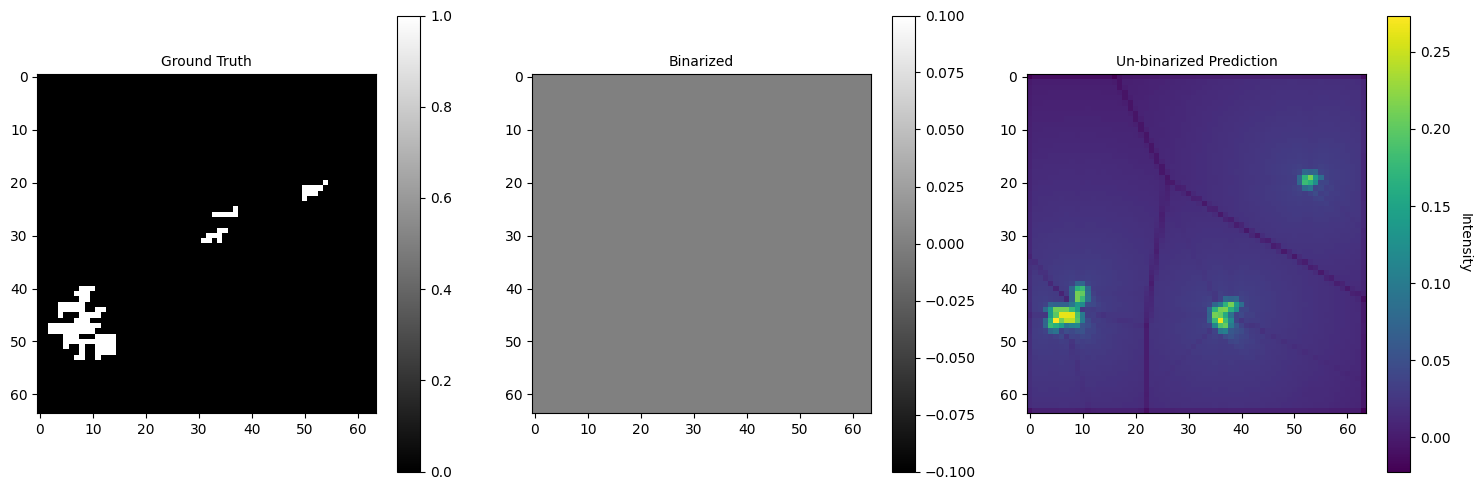

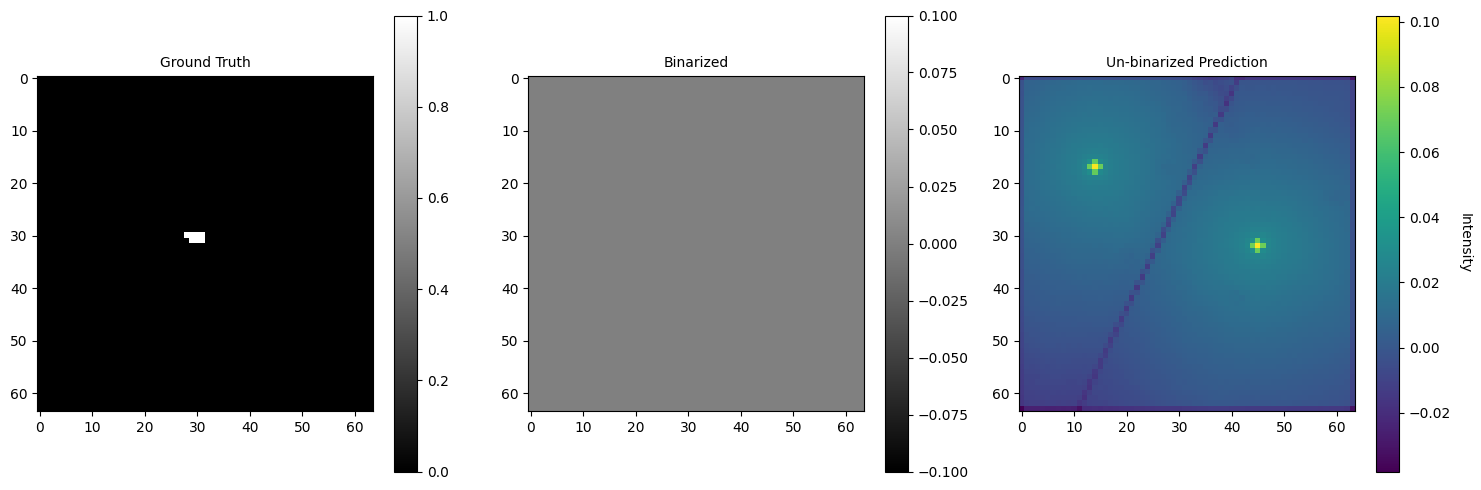

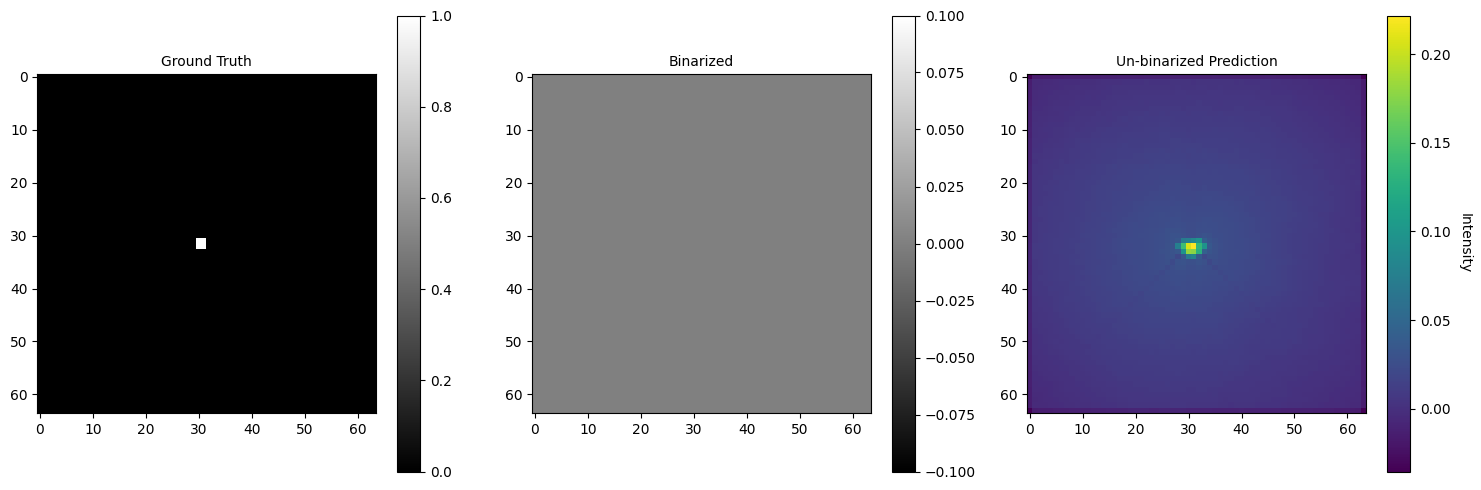

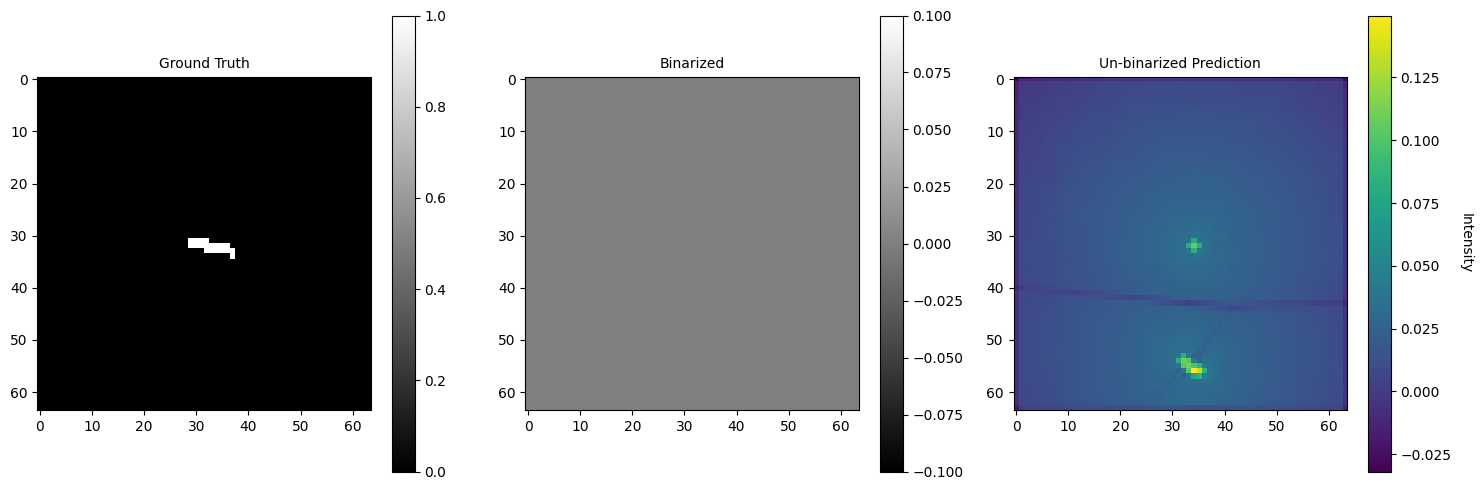

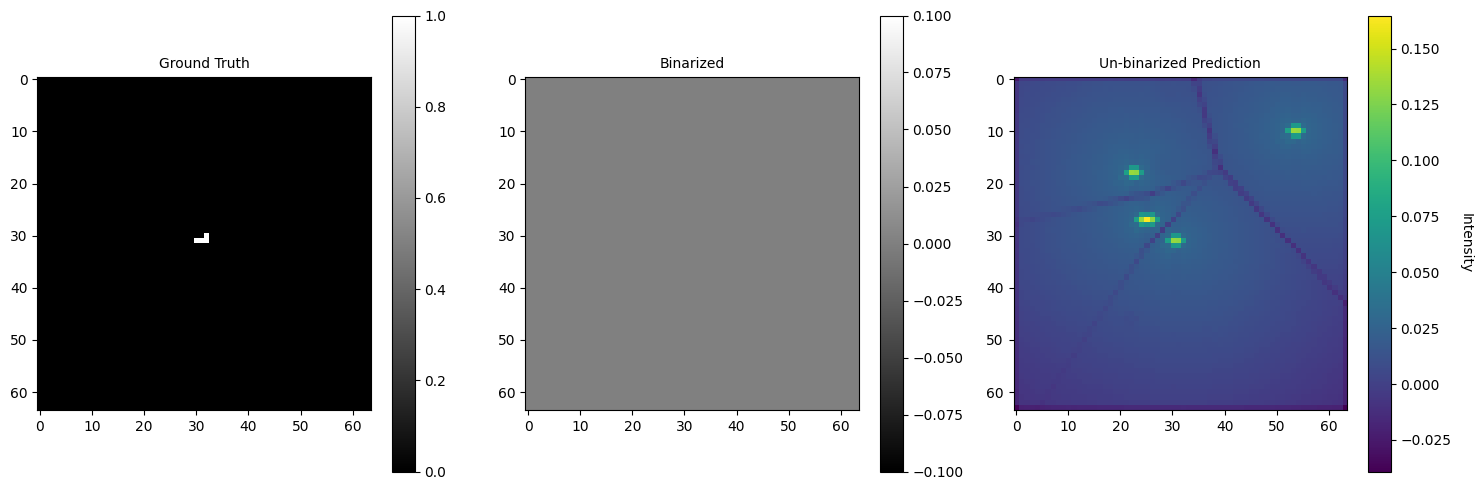

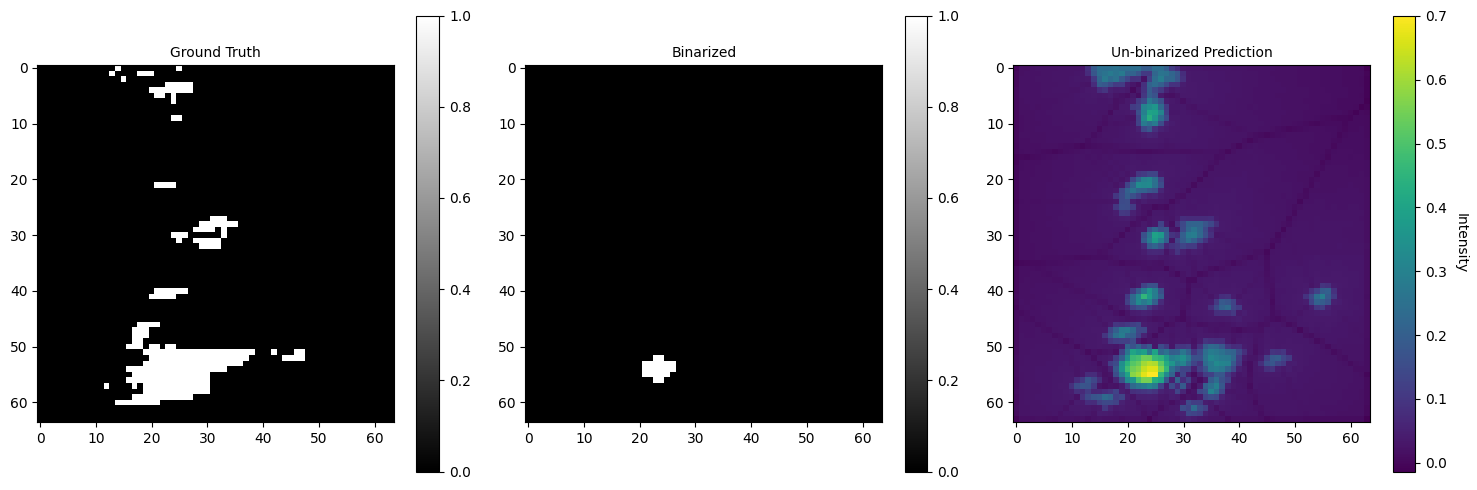

In [24]:
import matplotlib.pyplot as plt

for i in range(6):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # figsize to ensure enough space

    # Displaying the ground truth
    im1 = ax1.imshow(y_test_np[i,:,:,0], cmap='gray')  # Using grayscale colormap
    ax1.set_title("Ground Truth", fontsize=10)
    fig.colorbar(im1, ax=ax1)  # Optional: Add colorbar to ground truth if desired

    # Displaying the binarized prediction
    im2 = ax2.imshow(binarized_array[i,:,:,0], cmap='gray')
    ax2.set_title("Binarized", fontsize=10)
    fig.colorbar(im2, ax=ax2)  # Optional: Add colorbar to binarized if desired

    # Displaying the un-binarized prediction
    im3 = ax3.imshow(y_pred_reshaped[i,:,:,0], cmap='viridis')  # Assuming viridis colormap
    ax3.set_title("Un-binarized Prediction", fontsize=10)
    cbar = fig.colorbar(im3, ax=ax3)  # Adding colorbar to ax3
    cbar.set_label('Intensity', rotation=270, labelpad=15)  # Label the colorbar

    plt.tight_layout()  # Adjust layout to fit elements
    plt.show()  # Display the figure


In [25]:
y_test_np_flat = y_test_np.flatten()
binarized_array_flat = binarized_array.flatten()

# Calculate precision and recall
precision = precision_score(y_test_np_flat, binarized_array_flat)
recall = recall_score(y_test_np_flat, binarized_array_flat)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.27607361963190186
Recall: 0.007908889591901298
